# Valuación de opciones con barrera

## 1. Recorderis de valuación usando simulación...

In [89]:
#importar los paquetes que se van a usar
import pandas as pd
import pandas_datareader.data as web
import numpy as np
from sklearn.neighbors import KernelDensity
import datetime
from datetime import datetime, timedelta
import scipy.stats as stats
import scipy as sp
import scipy.optimize as optimize
import scipy.cluster.hierarchy as hac
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
#algunas opciones para Python
pd.set_option('display.notebook_repr_html', True)
pd.set_option('display.max_columns', 6)
pd.set_option('display.max_rows', 10)
pd.set_option('display.width', 78)
pd.set_option('precision', 3)

In [2]:
def get_historical_closes(ticker, start_date, end_date=None):
    #closes = web.YahooDailyReader(ticker, start_date, end_date).read().sort_index('major_axis')
    closes = web.YahooDailyReader(symbols=ticker, start=start_date, end=end_date).read()
    closes.set_axis(closes.loc['date',:,ticker[0]].values, axis=1, inplace=True)
    closes = closes.loc['adjclose'].sort_index().dropna()
    closes = pd.DataFrame(np.array(closes.as_matrix(), dtype=np.float64), columns=ticker, index=closes.index)
    closes.index.name = 'Date'
    #return closes.loc['Adj Close']
    return closes
####### Calculation of log-returns
def calc_daily_ret(closes):
    return np.log(closes/closes.shift(1)).dropna()

In [90]:
closes_aapl = get_historical_closes(['AAPL'], '2017-01-01')

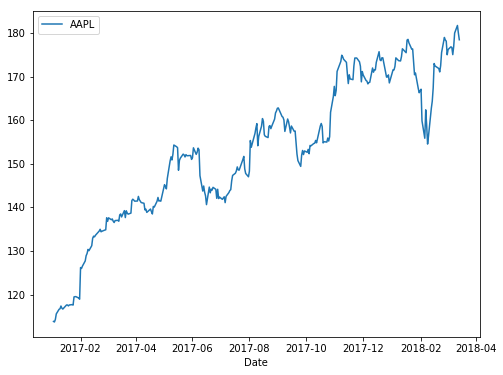

In [93]:
closes_aapl.plot(figsize=(8,6))

In [91]:
ret_aapl = calc_daily_ret(closes_aapl)

### 1.1 Modelo normal de rendimientos

In [92]:
mu = ret_aapl.mean().AAPL
sigma = ret_aapl.std().AAPL
r = 0.0160/252
mu, sigma, r

(0.0014979727368957033, 0.012018070762626952, 6.349206349206349e-05)

In [96]:
K = 180
ndays = (datetime(2018,6,15).date()-datetime(2018,3,14).date()).days
nscen = 100000
dates = pd.date_range('2018-03-15',periods=ndays).astype('str')
sim_ret = pd.DataFrame(sigma*np.random.randn(ndays,nscen)+r,index=dates)
sim_closes = (closes_aapl.iloc[-1].AAPL)*np.exp(sim_ret.cumsum())

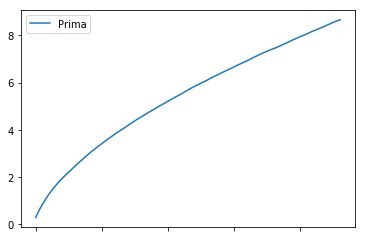

In [97]:
strike = pd.DataFrame(K*np.ones(ndays*nscen).reshape((ndays,nscen)),index=dates)
call=pd.DataFrame({'Prima':np.exp(-r*ndays)*np.fmax(sim_closes-strike,np.zeros(ndays*nscen).reshape((ndays,nscen))).T.mean()},index=dates)
call.plot();

In [98]:
call.iloc[-1]

Prima    8.652
Name: 2018-06-15, dtype: float64

In [99]:
sigma_est = sim_closes.iloc[-1].std()
(call.iloc[-1].Prima-1.96*sigma_est*np.exp(-r*ndays)/np.sqrt(nscen),call.iloc[-1].Prima+1.96*sigma_est*np.exp(-r*ndays)/np.sqrt(nscen))

(8.522631329418223, 8.7818191077035248)

### 1.2 Histograma de rendimientos

In [10]:
freq, values = np.histogram(ret_aapl-mu+r, bins=250)
freq = freq.astype('float32')
prob = freq/np.sum(freq)

In [100]:
K = 180
ndays = (datetime(2018,6,15).date()-datetime(2018,3,14).date()).days
nscen = 100000
dates = pd.date_range('2018-03-15',periods=ndays).astype('str')
ret = np.random.choice(values[1:], (ndays,nscen), p = prob)
sim_ret_hist = pd.DataFrame(ret,index=dates)
sim_closes_hist = (closes_aapl.iloc[-1].AAPL)*np.exp(sim_ret_hist.cumsum())

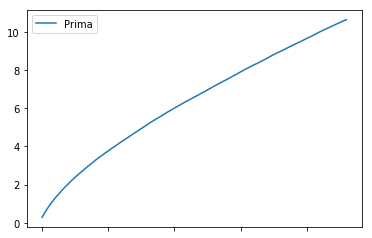

In [101]:
strike = pd.DataFrame(K*np.ones(ndays*nscen).reshape((ndays,nscen)), index=dates)
call_hist = pd.DataFrame({'Prima':np.exp(-r*ndays)*np.fmax(sim_closes_hist-strike,np.zeros(ndays*nscen).reshape((ndays,nscen))).T.mean()}, index=dates)
call_hist.plot();

In [102]:
call_hist.iloc[-1]

Prima    10.645
Name: 2018-06-15, dtype: float64

In [103]:
sigma_est = sim_closes_hist.iloc[-1].std()
(call_hist.iloc[-1].Prima-4.5*sigma_est*np.exp(-r*ndays)/np.sqrt(nscen),call_hist.iloc[-1].Prima+4.5*sigma_est*np.exp(-r*ndays)/np.sqrt(nscen))

(10.342849495593608, 10.94763673256945)

### 1.3 Distribución empírica con kernel

In [104]:
kde = KernelDensity(kernel='gaussian', bandwidth=0.001).fit(ret_aapl-mu+r)

In [105]:
K = 180
ndays = (datetime(2018,6,15).date()-datetime(2018,3,14).date()).days
nscen = 100000
dates = pd.date_range('2018-03-15',periods=ndays).astype('str')
kde = KernelDensity(kernel='gaussian', bandwidth=0.001).fit(ret_aapl-mu+r)
ret = kde.sample(n_samples=ndays*nscen, random_state=None)
sim_ret_kernel = pd.DataFrame(ret.reshape((ndays,nscen)),index=dates)
sim_closes_kernel = (closes_aapl.iloc[-1].AAPL)*np.exp(sim_ret_kernel.cumsum())

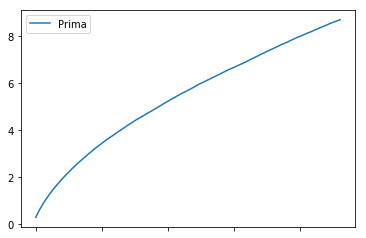

In [106]:
strike = pd.DataFrame(K*np.ones(ndays*nscen).reshape((ndays,nscen)), index=dates)
call_kernel = pd.DataFrame({'Prima':np.exp(-r*ndays)*np.fmax(sim_closes_kernel-strike,np.zeros(ndays*nscen).reshape((ndays,nscen))).T.mean()}, index=dates)
call_kernel.plot();

In [107]:
call_kernel.iloc[-1]

Prima    8.679
Name: 2018-06-15, dtype: float64

In [108]:
sigma_est = sim_closes_kernel.iloc[-1].std()
(call_kernel.iloc[-1].Prima-4.5*sigma_est*np.exp(-r*ndays)/np.sqrt(nscen),call_kernel.iloc[-1].Prima+4.5*sigma_est*np.exp(-r*ndays)/np.sqrt(nscen))

(8.3808795306568467, 8.9773825101152003)

## 2. Aspectos teóricos

Para un activo con precio $S_t$, se considera una opción de la siguiente forma
\begin{equation}
    V_T=u(t)F_T
\end{equation}
para $0\leq t\leq T$. En este caso, $F_T=\max(S_T-K,0)$ para una opción tipo call o $F_T=\max(K-S_T,0)$ para una opción tipo put. La función $u(t)$ est\'a definida en $0\leq t\leq T$, toma el valor de uno sí se cumple cierta condición y el valor de cero en otra caso. 

Por otra lado, para $B>0$ y $0<t<T$ se dice que $S_t$ ha superado la barrera $B$ sí $S_0<B$ y $S_t>B$ para algún tiempo $t$ en el periodo considerado. Similarmente, se dice que $S_t$ ha caído por debajo de la barrera $B$ sí $S_0>B$ y $S_t<B$ para alg\'un tiempo $t$ en el periodo considerado.

Finalmente, para un enunciado $x$, se define la función indicadora $I(x)$ como $I(x)=1$ si $x$ se cumple e $I(x)=0$ en otro caso.

Se esta forma, pueden definirse las siguientes acciones

* Up-and-out: Sí $S_0<B$, entonces $u(t)=I(S_t<B)$.
* Down-and-out: Sí $S_0>B$, entonces $u(t)=I(S_t>B)$.
* Up-and-in: Sí $S_0<B$, entonces $u(t)=I(S_t>B)$.
* Down-and-in: Sí $S_0>B$, entonces $u(t)=I(S_t<B)$.

Así se se pueden definirse ocho nuevos tipos de opciones. 

* Up-and-out call: Sí $S_0<B$, $C_t^{uo}=\max\{S_T-K,0\}I(S_t<B)$
* Down-and-out call: Sí $S_0>B$, $C_t^{do}=\max\{S_T-K,0\}I(S_t>B)$
* Up-and-in call: Sí $S_0<B$, $C_t^{ui}=\max\{S_T-K,0\}I(S_t>B)$
* Down-and-in call: Sí $S_0>B$, $C_t^{di}=\max\{S_T-K,0\}I(S_t<B)$
* Up-and-out put: Sí $S_0<B$, $P_t^{uo}=\max\{K-S_T,0\}I(S_t<B)$
* Down-and-out put: Sí $S_0>B$, $P_t^{do}=\max\{K-S_T,0\}I(S_t>B)$
* Up-and-in put: Sí $S_0<B$, $P_t^{ui}=\max\{K-S_T,0\}I(S_t>B)$
* Down-and-in put: Sí $S_0>B$, $P_t^{di}=\max\{K-S_T,0\}I(S_t<B)$


A las del tipo *up-and-out* y *down-and-out* se les conoce como opciones *knock-out*. De la misma forma, a las del tipo *up-and-in* y *down-and-in* se les conoce como opciones *knock-in*.

Note que estas son **opciones dependientes de la trayectoria del precio**, dado que $u(t)$ depende de $S_t$.

## 3. Valuación de una opción up and in

### 3.1 Modelo normal de rendimientos

In [109]:
mu = ret_aapl.mean().AAPL
sigma = ret_aapl.std().AAPL
r = 0.0160/252
mu, sigma, r

(0.0014979727368957033, 0.012018070762626952, 6.349206349206349e-05)

In [110]:
K = 180
B = 190
ndays = (datetime(2018,6,15).date()-datetime(2018,3,14).date()).days
nscen = 100000
dates = pd.date_range('2018-03-15',periods=ndays).astype('str')
sim_ret = pd.DataFrame(sigma*np.random.randn(ndays,nscen)+r,index=dates)
sim_closes = (closes_aapl.iloc[-1].AAPL)*np.exp(sim_ret.cumsum())

Hasta la simulación, todo normal... falta crear la función indicadora

In [114]:
barrier = pd.DataFrame(B*np.ones((ndays, nscen)),index=dates)
I = (sim_closes>barrier).cumsum()>0
I

,0,1,2,...,99997,99998,99999
2018-03-15,False,False,False,...,False,False,False
2018-03-16,False,False,False,...,False,False,False
2018-03-17,False,False,False,...,False,False,False
2018-03-18,False,False,False,...,False,False,False
2018-03-19,False,False,False,...,False,False,False
...,...,...,...,...,...,...,...
2018-06-11,False,False,True,...,False,True,True
2018-06-12,False,False,True,...,False,True,True
2018-06-13,False,False,True,...,False,True,True
2018-06-14,False,False,True,...,False,True,True


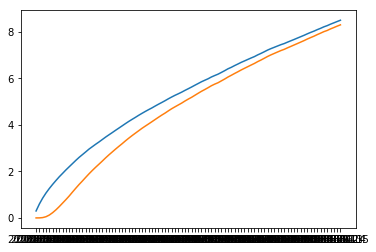

In [117]:
strike = pd.DataFrame(K*np.ones((ndays, nscen)),index=dates)
call = pd.DataFrame({'Prima':np.exp(-r*ndays)*np.fmax(sim_closes-strike,np.zeros(ndays*nscen).reshape((ndays,nscen))).T.mean()},index=dates)
callui = pd.DataFrame({'Prima':np.exp(-r*ndays)*(I*np.fmax(sim_closes-strike,np.zeros((ndays,nscen)))).T.mean()},index=dates)
plt.plot(call.index, call.Prima, callui.index, callui.Prima)
#callui.plot();
#call.plot();

In [118]:
call.iloc[-1]

Prima    8.502
Name: 2018-06-15, dtype: float64

In [119]:
callui.iloc[-1]

Prima    8.304
Name: 2018-06-15, dtype: float64

### 3.2 Distribución empírica con Kernel

In [121]:
kde = KernelDensity(kernel='gaussian', bandwidth=0.001).fit(ret_aapl-mu+r)

In [122]:
K = 180
B = 190
ndays = (datetime(2018,6,15).date()-datetime(2018,3,14).date()).days
nscen = 100000
dates = pd.date_range('2018-03-15',periods=ndays).astype('str')
kde = KernelDensity(kernel='gaussian', bandwidth=0.001).fit(ret_aapl-mu+r)
ret = kde.sample(n_samples=ndays*nscen, random_state=None)
sim_ret_kernel = pd.DataFrame(ret.reshape((ndays,nscen)),index=dates)
sim_closes_kernel = (closes_aapl.iloc[-1].AAPL)*np.exp(sim_ret_kernel.cumsum())

In [123]:
barrier = pd.DataFrame(B*np.ones((ndays, nscen)),index=dates)
I = (sim_closes_kernel>barrier).cumsum()>0
I

,0,1,2,...,99997,99998,99999
2018-03-15,False,False,False,...,False,False,False
2018-03-16,False,False,False,...,False,False,False
2018-03-17,False,False,False,...,False,False,False
2018-03-18,False,False,False,...,False,False,False
2018-03-19,False,False,False,...,False,False,False
...,...,...,...,...,...,...,...
2018-06-11,True,False,True,...,False,False,True
2018-06-12,True,False,True,...,False,False,True
2018-06-13,True,False,True,...,False,False,True
2018-06-14,True,False,True,...,False,False,True


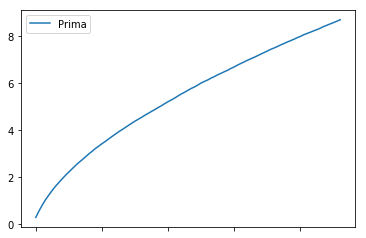

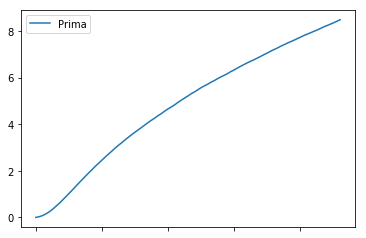

In [124]:
strike = pd.DataFrame(K*np.ones((ndays,nscen)), index=dates)
call_kernel = pd.DataFrame({'Prima':np.exp(-r*ndays)*np.fmax(sim_closes_kernel-strike,np.zeros(ndays*nscen).reshape((ndays,nscen))).T.mean()},index=dates)
callui_kernel = pd.DataFrame({'Prima':np.exp(-r*ndays)*(I*np.fmax(sim_closes_kernel-strike,np.zeros((ndays,nscen)))).T.mean()},index=dates)
call_kernel.plot();
callui_kernel.plot();

In [125]:
call_kernel.iloc[-1]

Prima    8.689
Name: 2018-06-15, dtype: float64

In [126]:
callui_kernel.iloc[-1]

Prima    8.482
Name: 2018-06-15, dtype: float64

**Tarea.** Montar la simulación para una opción put down-and-in.

<script>
  $(document).ready(function(){
    $('div.prompt').hide();
    $('div.back-to-top').hide();
    $('nav#menubar').hide();
    $('.breadcrumb').hide();
    $('.hidden-print').hide();
  });
</script>

<footer id="attribution" style="float:right; color:#808080; background:#fff;">
Created with Jupyter by Esteban Jiménez Rodríguez.
</footer>